In [9]:
import os
import re
import time
import string
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from IPython.display import clear_output
from datetime import timedelta

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
random_state = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

# Data Preprocessing 

In [3]:
df = pd.read_csv('fingpt_sentiment.csv')
df

,input,output
0,Starbucks says the workers violated safety pol...,negative
1,$brcm raises revenue forecast,positive
2,Google parent Alphabet Inc. reported revenue a...,negative
3,Here we highlight some top-ranked technology E...,positive
4,$UVXY Put the chum out there at key support th...,negative
...,...,...
124324,"BP, Statoil, to Withdraw Staff From Algeria Fo...",negative
124325,NEW YORK — A fire broke out late Wednesday at ...,mildly negative
124326,Operating profit margin increased from 11.2 % ...,positive
124327,$vxx adding to position here !,positive


In [4]:
df['output'].value_counts()

positive               52098
neutral                29215
negative               28796
moderately positive     6163
moderately negative     2972
mildly positive         2548
mildly negative         2108
strong negative          218
strong positive          211
Name: output, dtype: int64

---

FinBert labels: {'positive': 0, 'negative': 1, 'neutral': 2}

Our labels: {'negative / strong negative': 0, 'moderately / mildly negative': 1, 'neutral': 2, 'moderately / mildly positive': 3, 'positive / strong positive': 4}

---

In [5]:
def label_to_number(label):
    if label in ['negative', 'strong negative']:
        return 0
    if label in ['mildly negative', 'moderately negative']:
        return 1
    if label == 'neutral':
        return 2
    if label in ['moderately positive', 'mildly positive']:
        return 3
    if label in ['positive', 'strong positive']:
        return 4

In [6]:
df['output'] = df['output'].apply(lambda x: x.strip())
df['output'] = df['output'].apply(label_to_number)

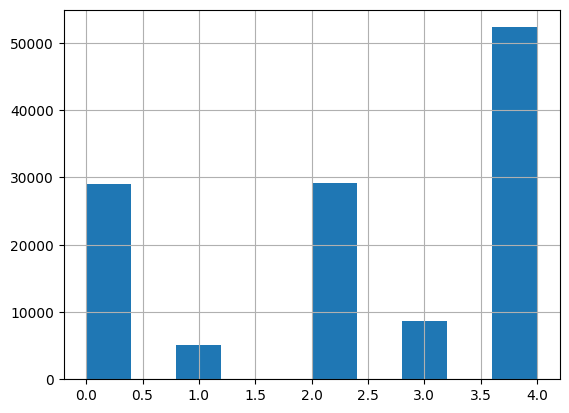

In [7]:
df['output'].hist()
plt.show()

In [8]:
list(df.sample(n=10)['input'])

["`` The transaction strengthens our position ... in design and branded goods , '' said Fiskars president and CEO Heikki Allonen , pointing out that the two groups have relatively few overlapping operations .",
 '$WYNN big bounce',
 'Grapevine city officials in September approved $ 35 million in tax rebates and grants for the expansion .',
 "The 250 sq m 2,691 sq ft store in Copenhagen 's premier shopping district was inaugurated today , further strengthening the company 's presence in Nordic capitals .",
 'S&P downgrades Barclays and RBS on government bailout fears',
 "Nokia said the outcome was a `` fair and responsible social plan . ''",
 'AMD gave an early warning on a subpar third quarter.',
 '$AMZN Trailing 12 months operating cash flow rose 48% to $4.98 billion & free cash flow decreased 63% to $388 million http://stks.co/c06zG',
 'The total headcount reduction will be 50 persons , the company said .',
 'OneWater Marine Inc. Prices Initial Public Offering']

In [9]:
def clean_text(text):
    text = str(text)
    # remove html tags 
    text = re.sub(r'<.*?>', '', text)
    # remove links 
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub('/', '', text)
    # replace spaces sequences with 1 space
    text = re.sub(r'\s+', ' ', text).strip()
    # replace ... with .
    text = re.sub(r'\.+', '.', text)
    
    return text

In [10]:
df['input'] = df['input'].apply(clean_text)

In [11]:
list(df.sample(n=10)['input'])

['Net sales increased to EUR655m in April to June 2010 from EUR438m a year earlier .',
 "Cadence's (CDNS) Q4 performance is likely to have benefited from its diversified product portfolio and recent acquisitions.",
 'When making a long-term commitment to a company, sustainable market leadership is everything.',
 'Rautaruukki said construction group YIT has awarded it a 2.5 mln eur contract to supply the steel structures for a new bridge spanning the Kemijoki river in Northern Finland .',
 'While I am watching ChatGPT, I am not terribly worried for GOOGL. The stock is trading at lower relative valuations than five years ago.',
 'Shares of chip and semiconductor stocks, including NVIDIA Corporation (NASDAQ:NVDA), are trading higher. A weekend report from the Semiconductor Industry Association showed November sales of $51.7B.',
 "According to Finnish Aktia Bank 's Managing Director Jussi Laitinen , the bank 's aim is to triple the number of its customers in Finland in the next five years 

# Train

In [23]:
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [24]:
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

Total parameters: 109484547


In [10]:
class TextsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
    
    def collate_fn(self, batch):
        max_len = max([len(item['input_ids']) for item in batch])

        input_ids = [item['input_ids'] for item in batch]
        attention_masks = [item['attention_mask'] for item in batch]
        labels = [item['labels'] for item in batch]

        padded_input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        padded_attention_masks = torch.nn.utils.rnn.pad_sequence(attention_masks, batch_first=True, padding_value=0)
        padded_labels = torch.stack(labels, dim=0)

        return {
            'input_ids': padded_input_ids,
            'attention_mask': padded_attention_masks,
            'labels': padded_labels
        }

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df['input'], df['output'], test_size=0.2, stratify=df['output'], random_state=random_state)
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
X_train.shape, X_test.shape

((99463,), (24866,))

In [27]:
train_dataset = TextsDataset(texts=X_train, labels=y_train, tokenizer=tokenizer)
test_dataset = TextsDataset(texts=X_test, labels=y_test, tokenizer=tokenizer)

batch_size = 64
num_workers = 28

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=train_dataset.collate_fn, shuffle=True, drop_last=True, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=test_dataset.collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)

In [4]:
class FinBert(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Unfreeze the last encoder block
        for param in self.model.bert.encoder.layer[-1].parameters():
            param.requires_grad = True
        
        self.model.classifier = torch.nn.Identity()
            
        self.fc = nn.Sequential(
            nn.Linear(768, 1024),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            
            nn.Linear(512, 5),
        )
        
    def forward(self, *args, **kwargs):
        x = self.model(*args, **kwargs).logits
        x = self.fc(x)
        return x

In [29]:
def train(model, optimizer, dataloader, criterion):
    model.train()
    losses_tr = []
    
    for batch in tqdm(dataloader):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        output = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())
    
    return model, optimizer, np.mean(losses_tr)


def val(model, dataloader, criterion):
    model.eval()
    losses_val = []
    
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            output = model(input_ids=input_ids, attention_mask=attention_mask)
            
            loss = criterion(output, labels)
            losses_val.append(loss.item())
            
            preds = torch.argmax(output, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    
    return np.mean(losses_val), accuracy

In [42]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    

def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler,
    model_name,
    epochs=10,
    val_every=1,
    checkpoints=True,
    checkpoint_folder='./checkpoints'
):
    losses = {'train': [], 'val': []}
    lrs = []
    accs = []
    best_val_loss = np.Inf
    
    if checkpoints and not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)
        
    writer = SummaryWriter(log_dir='./logs')
    
    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))
        
        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)
        
        writer.add_scalar('Loss/train', loss, epoch)
                
        if epoch % val_every == 0 or epoch == epochs:
            loss, accuracy = val(model, val_loader, criterion)
            losses['val'].append(loss)
            accs.append(accuracy)
            
            writer.add_scalar('Loss/val', loss, epoch)
            writer.add_scalar('Accuracy/val', accuracy, epoch)
            
            if loss < best_val_loss:
                best_val_loss = loss
                
                if checkpoints:
                    torch.save({
                            'epoch': epoch,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'scheduler_state_dict': scheduler.state_dict(),
                            'losses': losses,
                        },
                        os.path.join(chkp_folder, model_name + '.pt'),
                    )
                    
                clear_output(True)
                num_plots = 3  # loss, lr, accuracy

                fig, ax = plt.subplots(1, num_plots, figsize=(30, 10))

                plt.subplot(1, num_plots, 1)
                plt.plot(losses['train'], 'r.-', label='train')
                plt.plot(losses['val'], 'g.-', label='val')
                plt.title('loss')
                plt.legend()
                plt.grid()

                plt.subplot(1, num_plots, 2)
                plt.title('learning rate')
                plt.plot(lrs, 'g.-', label='lr')
                plt.yscale("log")
                plt.legend()
                plt.grid()

                plt.subplot(1, num_plots, 3)
                plt.plot(accs, '.-', label='accuracy')
                plt.title(f'accuracy')
                plt.legend()
                plt.grid()
                
                plt.show()
                
                print(f"loss train: {losses['train'][-1]} \nloss val: {losses['val'][-1]}\naccuracy: {accuracy}")
                    
        if scheduler:
            try:
                scheduler.step()
            except:
                scheduler.step(loss)
                
    return model, optimizer, losses

In [43]:
model = FinBert().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=7e-4)

warmup_epochs = 3
total_epochs = 30

warmup_scheduler = LinearLR(optimizer, start_factor=7e-4, total_iters=warmup_epochs)
cosine_scheduler = CosineAnnealingLR(optimizer, T_max=total_epochs - warmup_epochs)

scheduler = SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

criterion = nn.CrossEntropyLoss()

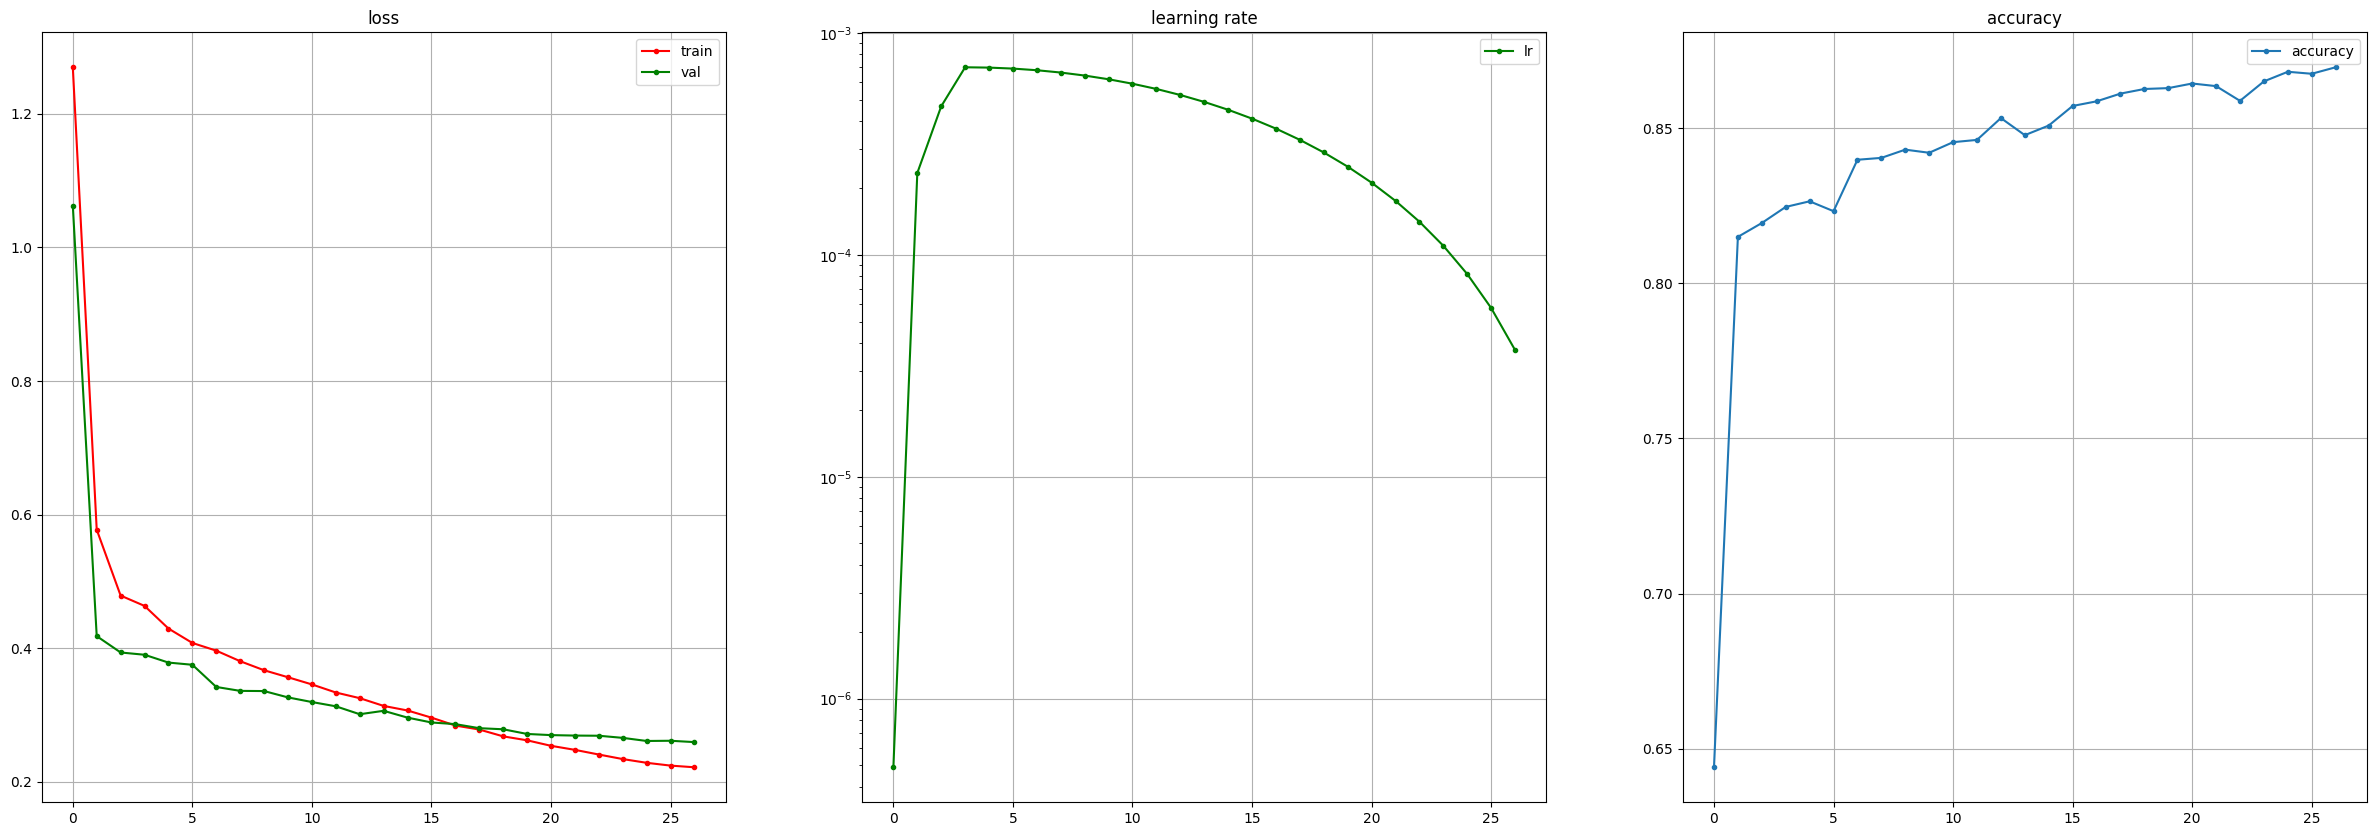

loss train: 0.2218475531033951 
loss val: 0.2595223166565662
accuracy: 0.8695809539129735
#28/30:


100%|██████████| 389/389 [00:25<00:00, 15.01it/s]


#29/30:


100%|██████████| 389/389 [00:25<00:00, 15.00it/s]


#30/30:


100%|██████████| 389/389 [00:25<00:00, 14.97it/s]

CPU times: user 1h 12min 29s, sys: 2min 42s, total: 1h 15min 12s
Wall time: 1h 13min 26s


In [44]:
%%time

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = train_dataloader,
    val_loader = test_dataloader,
    criterion = criterion,
    scheduler = scheduler,
    model_name = "finbert#1",
    epochs = total_epochs,
    val_every = 1,
    checkpoints=False
)

In [45]:
torch.save(model.state_dict(), "finbert.pth")

In [57]:
def confmatrix(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).detach().cpu()
            
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.detach().cpu().numpy())
            y_pred.extend(predicted.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Neg', 'Mid Neg', 'Neutral', 'Mid Pos', 'Pos'],
                yticklabels=['Neg', 'Mid Neg', 'Neutral', 'Mid Pos', 'Pos'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [46]:
bert = FinBert()
bert.load_state_dict(torch.load("finbert.pth"))

<All keys matched successfully>

In [48]:
bert = bert.to(device)
val(bert, test_dataloader, criterion)

100%|██████████| 389/389 [00:25<00:00, 15.02it/s]


(0.2615971479248878, 0.8692190139145821)

100%|██████████| 389/389 [00:25<00:00, 14.97it/s]


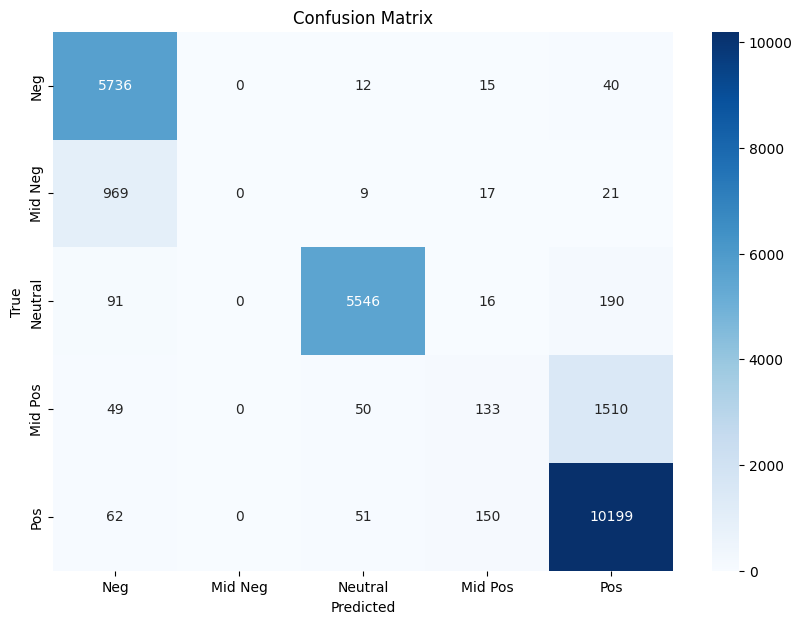

In [58]:
confmatrix(bert, test_dataloader)

# Make predictions for main dataset

In [8]:
bert = FinBert()
bert.load_state_dict(torch.load("finbert.pth"))
bert = bert.to(device)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

In [39]:
df = pd.read_parquet(os.path.join('.', 'data', 'nasdaq30_news.parquet'))
df

,datetime,ticker,title,text
0,2024-01-09 00:00:00+00:00,AMD,Is iShares Semiconductor ETF (SOXX) a Strong E...,The iShares Semiconductor ETF (SOXX) was launc...
1,2024-01-09 00:00:00+00:00,AMD,"Stock Market News for Jan 9, 2024",U.S. stock markets closed sharply higher on Mo...
2,2024-01-09 00:00:00+00:00,AMD,Japan's Nikkei hits 33-year high as tech stock...,"TOKYO, Jan 9 (Reuters) - Japan's Nikkei share ..."
3,2024-01-09 00:00:00+00:00,AMD,Will Advanced Micro Devices Be a Trillion-Doll...,The trillion-dollar club is certainly rarified...
4,2024-01-09 00:00:00+00:00,AMD,Zacks Industry Outlook Highlights Advanced Mic...,"For Immediate Release\nChicago, IL – January 9..."
...,...,...,...,...
111889,2012-01-06 00:00:00+00:00,ADI,16 Stocks Picked by Prize-Winning Fund Managers,16 Stocks Picked by Prize-Winning Fund Managers
111890,2012-01-05 00:00:00+00:00,ADP,Good News for U.S. Labor Market - Analyst Blog,Positive domestic data and the resumption of E...
111891,2012-01-05 00:00:00+00:00,ADP,"Ahead of Wall Street - January 5, 2012 - Ahead...","Thursday, January 5, 2012\nPositive domestic d..."
111892,2012-01-05 00:00:00+00:00,AMGN,Hospira Upped to Neutral - Analyst Blog,"We recently upgraded our rating on Hospira, In..."


In [46]:
dummy_labels = np.zeros(len(df))

texts_dataset = TextsDataset(texts=df['text'], labels=dummy_labels, tokenizer=tokenizer)
titles_dataset = TextsDataset(texts=df['title'], labels=dummy_labels, tokenizer=tokenizer)

batch_size = 128
num_workers = 8

texts_dataloader = DataLoader(texts_dataset, batch_size=batch_size, collate_fn=texts_dataset.collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)
titles_dataloader = DataLoader(titles_dataset, batch_size=batch_size, collate_fn=titles_dataset.collate_fn, shuffle=False, drop_last=False, num_workers=num_workers)

In [47]:
def get_predictions(model, dataloader):
    preds = []
    for batch in tqdm(dataloader):
        input_ids, attention_mask, labels = batch['input_ids'], batch['attention_mask'], batch['labels']
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask).detach().cpu()
        probs = F.softmax(outputs, dim=-1)
        
        preds.append(probs)
        
    return torch.cat(preds, dim=0)

In [ ]:
text_preds = get_predictions(bert, texts_dataloader)
title_preds = get_predictions(bert, titles_dataloader)

100%|██████████| 875/875 [01:19<00:00, 10.97it/s]


In [51]:
text_preds = text_preds.tolist()
title_preds = title_preds.tolist()

In [54]:
# Our labels: {'negative / strong negative': 0, 'moderately / mildly negative': 1, 'neutral': 2, 'moderately / mildly positive': 3, 'positive / strong positive': 4}

In [55]:
df['text_neg'] = [x[0] for x in text_preds]
df['text_midneg'] = [x[1] for x in text_preds]
df['text_neutral'] = [x[2] for x in text_preds]
df['text_midpos'] = [x[3] for x in text_preds]
df['text_pos'] = [x[4] for x in text_preds]

df['title_neg'] = [x[0] for x in title_preds]
df['title_midneg'] = [x[1] for x in title_preds]
df['title_neutral'] = [x[2] for x in title_preds]
df['title_midpos'] = [x[3] for x in title_preds]
df['title_pos'] = [x[4] for x in title_preds]

In [56]:
df

,datetime,ticker,title,text,text_neg,text_midneg,text_neutral,text_midpos,text_pos,title_neg,title_midneg,title_neutral,title_midpos,title_pos
0,2024-01-09 00:00:00+00:00,AMD,Is iShares Semiconductor ETF (SOXX) a Strong E...,The iShares Semiconductor ETF (SOXX) was launc...,3.472141e-04,9.923942e-09,6.481437e-01,2.195085e-06,0.351507,2.457909e-04,2.106507e-08,9.997539e-01,3.247099e-09,2.189179e-07
1,2024-01-09 00:00:00+00:00,AMD,"Stock Market News for Jan 9, 2024",U.S. stock markets closed sharply higher on Mo...,5.480200e-09,6.135955e-12,1.698356e-03,7.098104e-05,0.998231,2.233719e-03,2.587011e-03,8.843381e-01,4.966966e-02,6.117157e-02
2,2024-01-09 00:00:00+00:00,AMD,Japan's Nikkei hits 33-year high as tech stock...,"TOKYO, Jan 9 (Reuters) - Japan's Nikkei share ...",1.517264e-01,2.504872e-03,3.302018e-03,5.241840e-03,0.837225,6.833132e-08,1.470511e-20,3.443936e-13,8.138968e-13,9.999999e-01
3,2024-01-09 00:00:00+00:00,AMD,Will Advanced Micro Devices Be a Trillion-Doll...,The trillion-dollar club is certainly rarified...,1.677820e-04,1.607691e-07,5.385148e-07,3.259737e-04,0.999506,1.837178e-02,1.881204e-02,5.120176e-04,4.785705e-01,4.837336e-01
4,2024-01-09 00:00:00+00:00,AMD,Zacks Industry Outlook Highlights Advanced Mic...,"For Immediate Release\nChicago, IL – January 9...",5.168036e-01,8.543725e-02,1.411705e-02,4.822003e-02,0.335422,4.915071e-03,4.201150e-03,4.869574e-02,4.489187e-01,4.932694e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111889,2012-01-06 00:00:00+00:00,ADI,16 Stocks Picked by Prize-Winning Fund Managers,16 Stocks Picked by Prize-Winning Fund Managers,8.066183e-05,5.884419e-05,9.618504e-01,1.700314e-02,0.021007,1.190474e-02,1.243878e-02,5.002770e-01,2.584815e-01,2.168981e-01
111890,2012-01-05 00:00:00+00:00,ADP,Good News for U.S. Labor Market - Analyst Blog,Positive domestic data and the resumption of E...,5.571148e-02,4.871891e-02,4.629497e-03,4.053663e-01,0.485574,1.587326e-03,2.200699e-07,2.817411e-03,8.171409e-06,9.955869e-01
111891,2012-01-05 00:00:00+00:00,ADP,"Ahead of Wall Street - January 5, 2012 - Ahead...","Thursday, January 5, 2012\nPositive domestic d...",9.572425e-02,9.372959e-02,5.995124e-04,4.003055e-01,0.409641,5.424077e-04,4.892219e-04,9.016530e-01,4.975015e-02,4.756521e-02
111892,2012-01-05 00:00:00+00:00,AMGN,Hospira Upped to Neutral - Analyst Blog,"We recently upgraded our rating on Hospira, In...",1.847468e-02,1.645803e-02,4.938887e-03,4.641894e-01,0.495939,5.854712e-04,4.125423e-08,2.544502e-06,9.577920e-06,9.994024e-01


In [57]:
df.to_parquet(os.path.join('.', 'data', 'nasdaq30_news.parquet'))